<a href="https://colab.research.google.com/github/lucas-aranha/effect-of-climatic-factors-on-dengue-dynamics-in-belem/blob/main/proj1_den_belem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 Definicação de funções**

### 1.1 Importação de Bibliotecas

In [ ]:
import numpy            as np
import pandas           as pd
import statsmodels.api  as sm
import seaborn          as sns
import matplotlib.pylab as plt
import scipy.stats      as stats

###  1.2   Função para leitura dos datasets



In [ ]:
def load_dataset(filename):

    data_base = pd.read_excel(filename, index_col=0)
    
    return data_base

###  1.3   Função de amplitude-média

In [ ]:
def amplitude_average(dataframe):

  mean_df = dataframe.groupby(dataframe.index.year).mean()
  max_df = dataframe.groupby(dataframe.index.year).max()
  min_df = dataframe.groupby(dataframe.index.year).min()
  w_df = max_df - min_df

  return mean_df, w_df

###  1.4 Função Teste de Cox-Stuart

In [ ]:
def cox_stuart(timeseries):

  n = len(timeseries)
  timeseries_c = timeseries
  if n % 2 == 1:
    del timeseries_c[n // 2]
  c = n // 2

  n_pos = n_neg = 0
  for i in range(c):
    diff = timeseries_c[i + c] - timeseries[i]
    if diff > 0:
      n_pos += 1
    elif diff < 0:
      n_neg += 1
    else:
      continue

  number = n_pos + n_neg
  k = min(n_pos, n_neg)
  p_value = 2 * stats.binom.cdf(k, number, 0.5)
  print('fall:{}, rise:{}, p-value:{}'.format(n_neg, n_pos, p_value))

  if n_pos > n_neg and p_value < 0.05:
    return 'Increasing'
  elif n_neg > n_pos and p_value < 0.05:
    return 'Decreasing'
  else:
    return 'No trend'

###  1.5 Função Teste de Kruskal-Wallis

In [ ]:
def kruskal_wallis(timeseries):

  from scipy import stats
  
  array = timeseries.to_numpy()

  n = int(len(timeseries) / 12)
  years = np.zeros([n, 12], dtype=int)

  i, j = 0, 12
  while i < n:
    years[i, :] = array[j-12:j]
    i += 1
    j += 12

  k_w = stats.kruskal(years[0, :], years[1, :], years[2, :], years[3, :], 
                       years[4, :], years[5, :], years[6, :], years[7, :], 
                       years[8, :], years[9, :], years[10, :], years[11, :], 
                       years[12, :], years[13, :])
  if k_w[1] <= 0.05:
    return 'p-value:{}. This serie is seasonal'.format(k_w[1])
  else:
    return 'p-value:{}. No seasonal'.format(k_w[1])

###  1.6 Função Augmented Dickey-Fuller test

In [ ]:
def test_stationarity(timeseries):

  from statsmodels.tsa.stattools import adfuller

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

###  1.7 Função de transformação

In [ ]:
def log_scale(timeseries):

  ln = np.log(timeseries + 1)
  ln_ts = pd.Series(ln, timeseries.index)

  return ln_ts

###  1.8 Função para plotagem da ACF PACF

In [ ]:
def acf_pacf(dataframe, lags, color):

  fig7, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

  sm.graphics.tsa.plot_acf(dataframe.values.squeeze(), lags=lags, ax=ax1, color=color)
  sm.graphics.tsa.plot_pacf(dataframe.values.squeeze(), lags=lags, ax=ax2, color=color)

  plt.show()

# **2 Visualização e preparação dos dados**


### 2.1   Leitura dos datasets

In [ ]:
data_set = load_dataset('belem_dengue_clima_mensal_2007-2020.xlsx')
data_set

,mean_temperature,max_temperature,min_temperature,mean_humidity,total_preciptation,mean_wind_speed,dengue_cases
date,,,,,,,
2007-01-01,26.921237,33.4,22.8,82.818548,331.4,1.117204,220
2007-02-01,25.749702,32.0,22.5,85.764881,356.6,1.057292,364
2007-03-01,25.683065,31.8,22.7,87.197581,404.2,0.716398,544
2007-04-01,25.958750,31.9,22.0,86.331944,460.8,0.835972,327
2007-05-01,26.553629,33.1,22.3,83.975806,228.6,0.865995,117
...,...,...,...,...,...,...,...
2020-08-01,28.195296,35.5,22.1,72.000000,107.6,0.875000,3
2020-09-01,27.742222,34.7,22.8,75.552778,138.4,0.708472,5
2020-10-01,27.264516,34.0,22.6,78.405914,255.2,0.607124,2


### 2.2   Plotagem das séries temporais

2.2.1   Casos de dengue

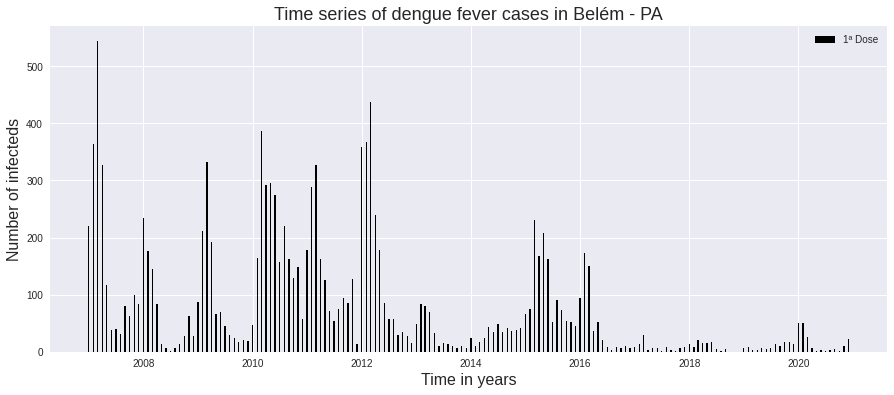

In [ ]:
plt.style.use('seaborn')

fig1, ax = plt.subplots(figsize=(15, 6))

#ax.plot(data_set.index, data_set.dengue_cases, color='black', label='Dengue fever cases')
ax.bar(data_set.index, data_set.dengue_cases, 9, color='#000000', error_kw={'ecolor': '0.3'}, label='1ª Dose')

ax.set_title('Time series of dengue fever cases in Belém - PA', size=18)
ax.set_xlabel('Time in years', size=16)
ax.set_ylabel('Number of infecteds', size=16)
ax.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


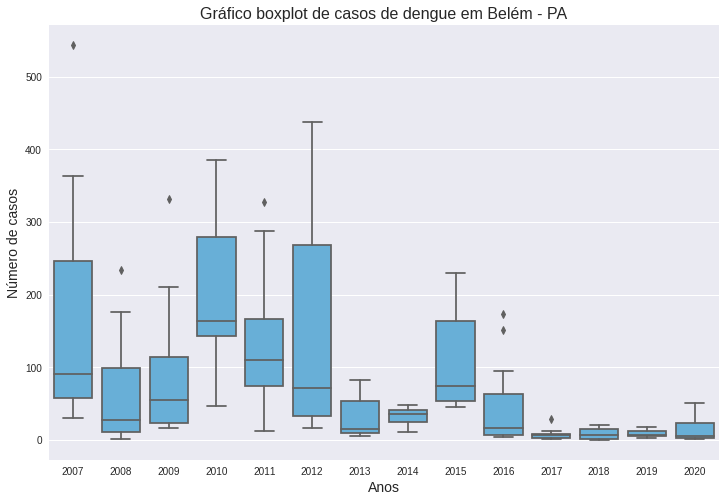

In [ ]:
fig2, ax = plt.subplots(figsize=(12,8))

sns.boxplot(data_set.index.year, data_set.dengue_cases, ax=ax, color='#56B4E9')
ax.set_title('Gráfico boxplot de casos de dengue em Belém - PA', size=16)
ax.set_xlabel('Anos', size=14)
ax.set_ylabel('Número de casos', size=14)

plt.show();



2.2.2   Variáveis climáticas



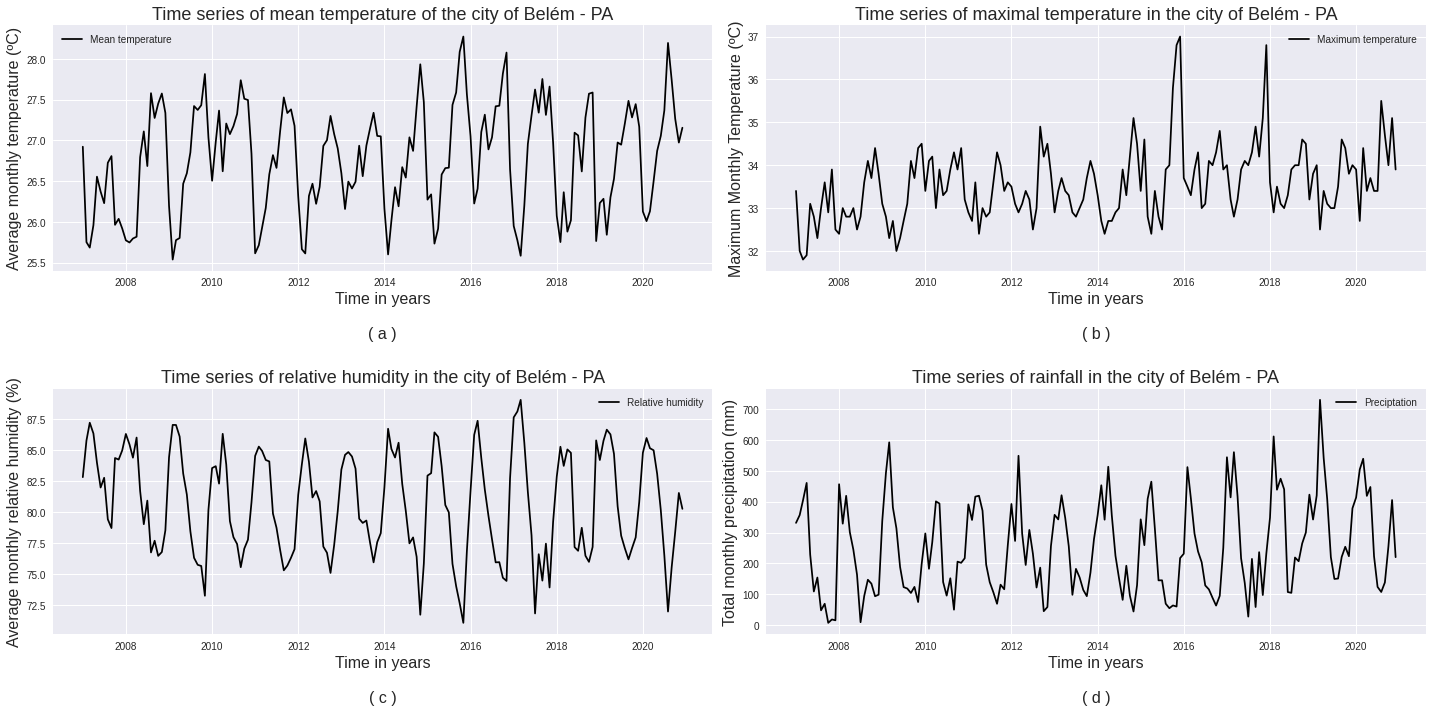

In [ ]:
fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ax1.plot(data_set.index, data_set.mean_temperature, color='black', label='Mean temperature')

ax1.set_title('Time series of mean temperature of the city of Belém - PA', size=18)
ax1.set_xlabel('Time in years''\n''\n( a )''\n', size=16)
ax1.set_ylabel('Average monthly temperature (ºC)', size=16)
ax1.legend()

ax2.plot(data_set.index, data_set.max_temperature, color='black', label='Maximum temperature')

ax2.set_title('Time series of maximal temperature in the city of Belém - PA', size=18)
ax2.set_xlabel('Time in years''\n''\n( b )', size=16)
ax2.set_ylabel('Maximum Monthly Temperature (ºC)', size=16)
ax2.legend()

ax3.plot(data_set.index, data_set.mean_humidity, color='black', label='Relative humidity')

ax3.set_title('Time series of relative humidity in the city of Belém - PA', size=18)
ax3.set_xlabel('Time in years''\n''\n( c )', size=16)
ax3.set_ylabel('Average monthly relative humidity (%)', size=16)
ax3.legend()

ax4.plot(data_set.index, data_set.total_preciptation, color='black', label='Preciptation')

ax4.set_title('Time series of rainfall in the city of Belém - PA', size=18)
ax4.set_xlabel('Time in years''\n''\n( d )', size=16)
ax4.set_ylabel('Total monthly precipitation (mm)', size=16)
ax4.legend()

plt.tight_layout()

plt.show()

### 2.3 Transformação dos dados



2.3.1 Verificação da proporcionalidade das médias



In [ ]:
mean_dengue, w_dengue = amplitude_average(data_set.dengue_cases)
mean_temperature, w_temperature = amplitude_average(data_set.mean_temperature)
mean_max_temperature, w_max_temperature = amplitude_average(data_set.mean_temperature)
mean_humidity, w_humidity = amplitude_average(data_set.mean_humidity)
mean_preciptation, w_preciptation = amplitude_average(data_set.total_preciptation)

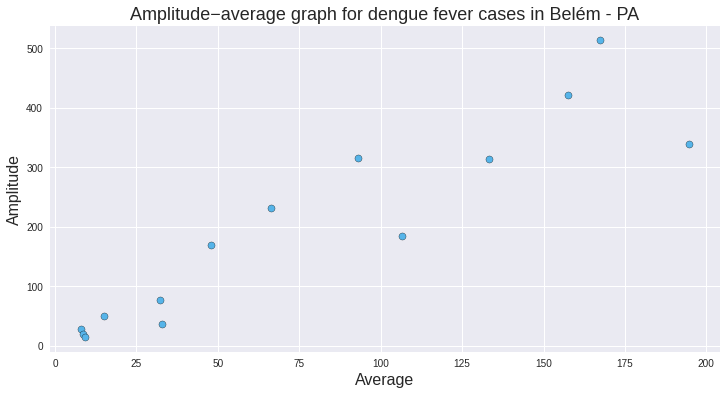

In [ ]:
fig4, ax = plt.subplots(figsize=(12, 6))

ax.scatter(mean_dengue, w_dengue, s=50, edgecolor='black', c='#56B4E9')

ax.set_title('Amplitude−average graph for dengue fever cases in Belém - PA', size=18)
ax.set_xlabel('Average', size=16)
ax.set_ylabel('Amplitude', size=16)

plt.show();

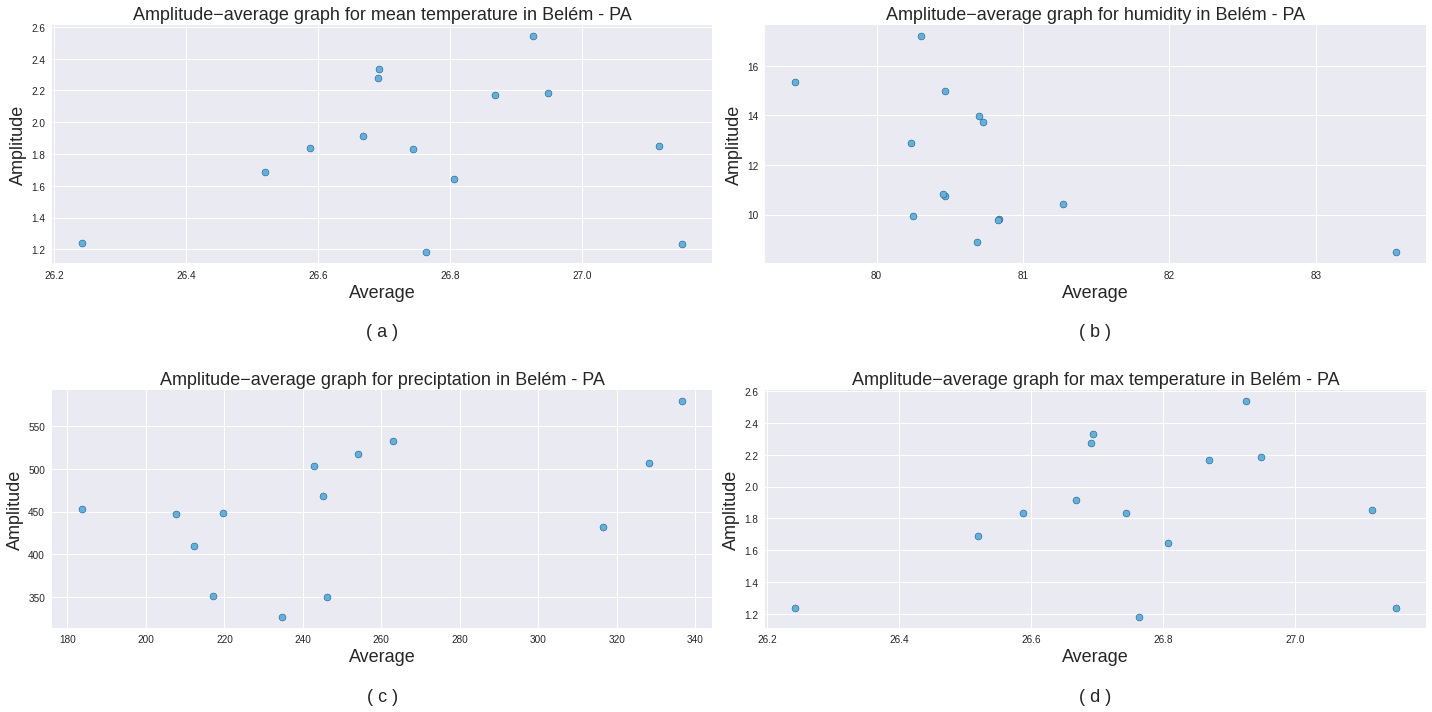

In [ ]:
fig5, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ax1.scatter(mean_temperature, w_temperature, color='#56B4E9', edgecolor='black')

ax1.set_title('Amplitude−average graph for mean temperature in Belém - PA', size=18)
ax1.set_xlabel('Average''\n''\n( a )''\n', size=18)
ax1.set_ylabel('Amplitude', size=18)

ax2.scatter(mean_humidity, w_humidity, color='#56B4E9', edgecolor='black')

ax2.set_title('Amplitude−average graph for humidity in Belém - PA', size=18)
ax2.set_xlabel('Average''\n''\n( b )', size=18)
ax2.set_ylabel('Amplitude', size=18)

ax3.scatter(mean_preciptation, w_preciptation, color='#56B4E9', edgecolor='black')

ax3.set_title('Amplitude−average graph for preciptation in Belém - PA', size=18)
ax3.set_xlabel('Average''\n''\n( c )', size=18)
ax3.set_ylabel('Amplitude', size=18)

ax4.scatter(mean_max_temperature, w_max_temperature, color='#56B4E9', edgecolor='black')

ax4.set_title('Amplitude−average graph for max temperature in Belém - PA', size=18)
ax4.set_xlabel('Average''\n''\n( d )', size=18)
ax4.set_ylabel('Amplitude', size=18)

plt.tight_layout()

plt.show()

2.3.2 Logaritmização da série

In [ ]:
dengue_log = log_scale(data_set.dengue_cases)
moving_avg = dengue_log.ewm(span=7).mean()

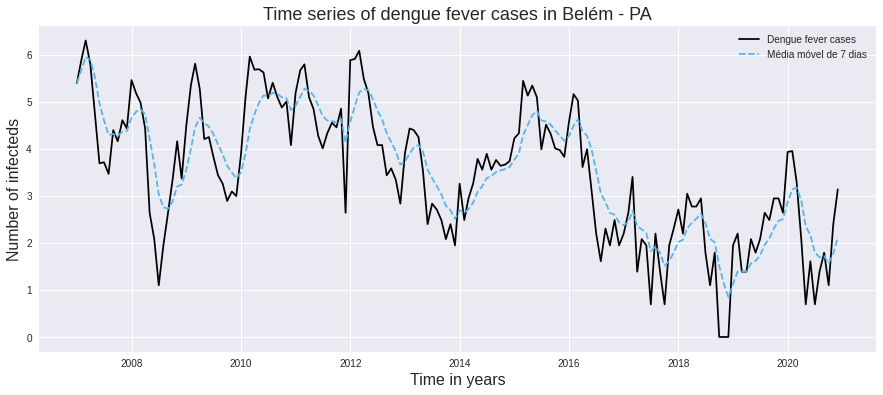

In [ ]:
fig6, ax = plt.subplots(figsize=(15, 6))

ax.plot(dengue_log.index, dengue_log, color='black', label='Dengue fever cases')
ax.plot(dengue_log.index, moving_avg, color='#56B4E9', linestyle='--', label='Média móvel de 7 dias')

ax.set_title('Time series of dengue fever cases in Belém - PA', size=18)
ax.set_xlabel('Time in years', size=16)
ax.set_ylabel('Number of infecteds', size=16)
ax.legend()

plt.show()

### 2.4 Tendência e Sazonalidade

2.4.1 Testes de hipóteses

In [ ]:
print(cox_stuart(dengue_log))

fall:69, rise:14, p-value:6.802593482929834e-10
Decreasing


In [ ]:
print(kruskal_wallis(dengue_log))

p-value:3.0324256342664704e-15. This serie is seasonal


2.4.2 Funções de Autocorrelação e Autocorrelação Parcial

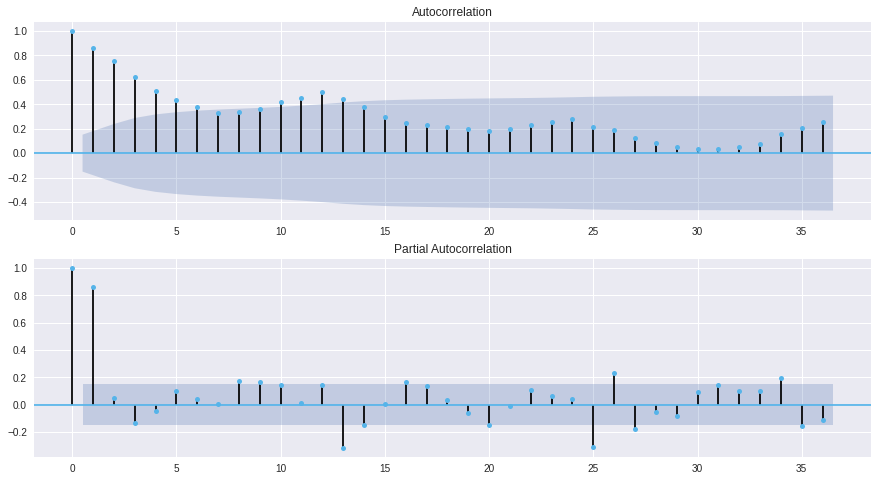